### 2-D Image Segmentation

- **Author:** Dhananjay Bhaskar (<dhananjay_bhaskar@brown.edu>)
- **Date:** July 13, 2018

Based on EMBL Python image processing workshop:
https://github.com/karinsasaki/python-workshop-image-processing

In [1]:
from __future__ import division

import numpy as np                 
import matplotlib.pyplot as plt    

from ipywidgets import interact, fixed

import skimage.io as io
import scipy.ndimage as ndi

from skimage.filters import threshold_otsu, threshold_local, threshold_yen, try_all_threshold

Image Source:
- Confluent epithelial-like cells
- 2D confocal fluorescence microscopy
- Dual-color spinning-disc confocal micrographs (40x)
- Two membrane-localized proteins during zebrafish early embryonic development

In [2]:
filename = "example_cells_1.tif"
img = io.imread(filename)   
print "Image data type: " + repr(img.dtype)
print "Loaded array has shape" + repr(img.shape)
(nchannels, height, width) = img.shape

Image data type: dtype('uint8')
Loaded array has shape(2, 930, 780)


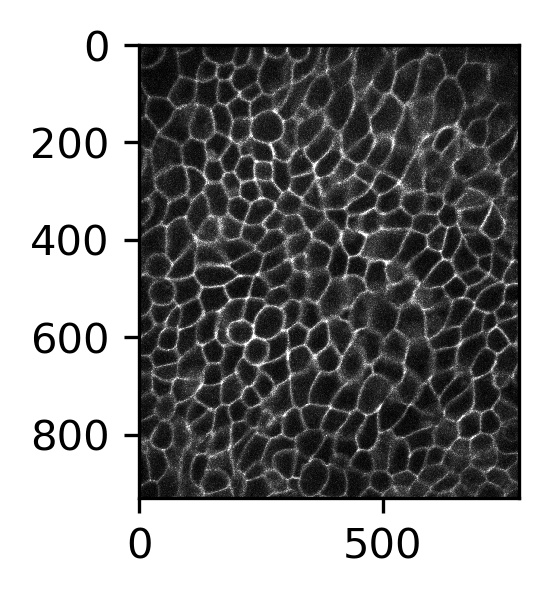

In [3]:
plt.figure(figsize=(2,2), dpi=300)
plt.imshow(img[0,:,:], cmap='gray')
plt.show()

Combine channels to produce colored image

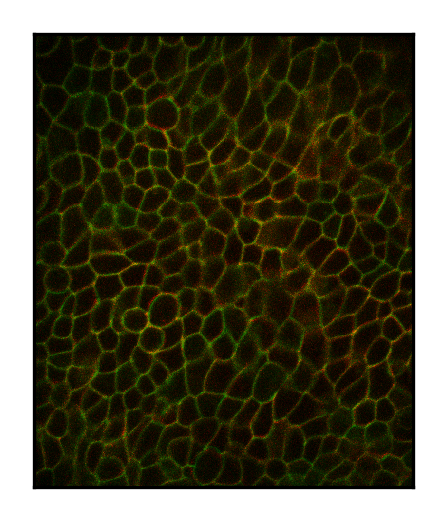

In [4]:
green = img[0,:,:]
red = img[1,:,:]

rgbImage = np.zeros((height,width,3), 'uint8')
rgbImage[:,:,0] = red
rgbImage[:,:,1] = green*0.5

plt.figure(figsize=(2,2), dpi=300)
plt.imshow(rgbImage)
plt.xticks([])
plt.yticks([])
plt.show()

#### Pre-processing
- Gaussian smoothing
- Adaptive thresholding

In [5]:
@interact(sigma=(1,20))
def smoothing(sigma):
    green_smooth = ndi.filters.gaussian_filter(green,sigma)
    plt.figure(figsize=(2,2), dpi=300)
    plt.imshow(green_smooth, interpolation='none', cmap='gray')
    plt.show()

interactive(children=(IntSlider(value=10, description=u'sigma', max=20, min=1), Output()), _dom_classes=('widget-interact',))

In [6]:
green_smooth = ndi.filters.gaussian_filter(green, 3)

Try multiple thresholding methods

skimage.filters.thresholding.threshold_triangle
skimage.filters.thresholding.threshold_yen
skimage.filters.thresholding.threshold_li
skimage.filters.thresholding.threshold_isodata
skimage.filters.thresholding.threshold_minimum
skimage.filters.thresholding.threshold_otsu
skimage.filters.thresholding.threshold_mean


(<matplotlib.figure.Figure at 0x7ff984a06f90>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7ff984acb990>,
       dtype=object))

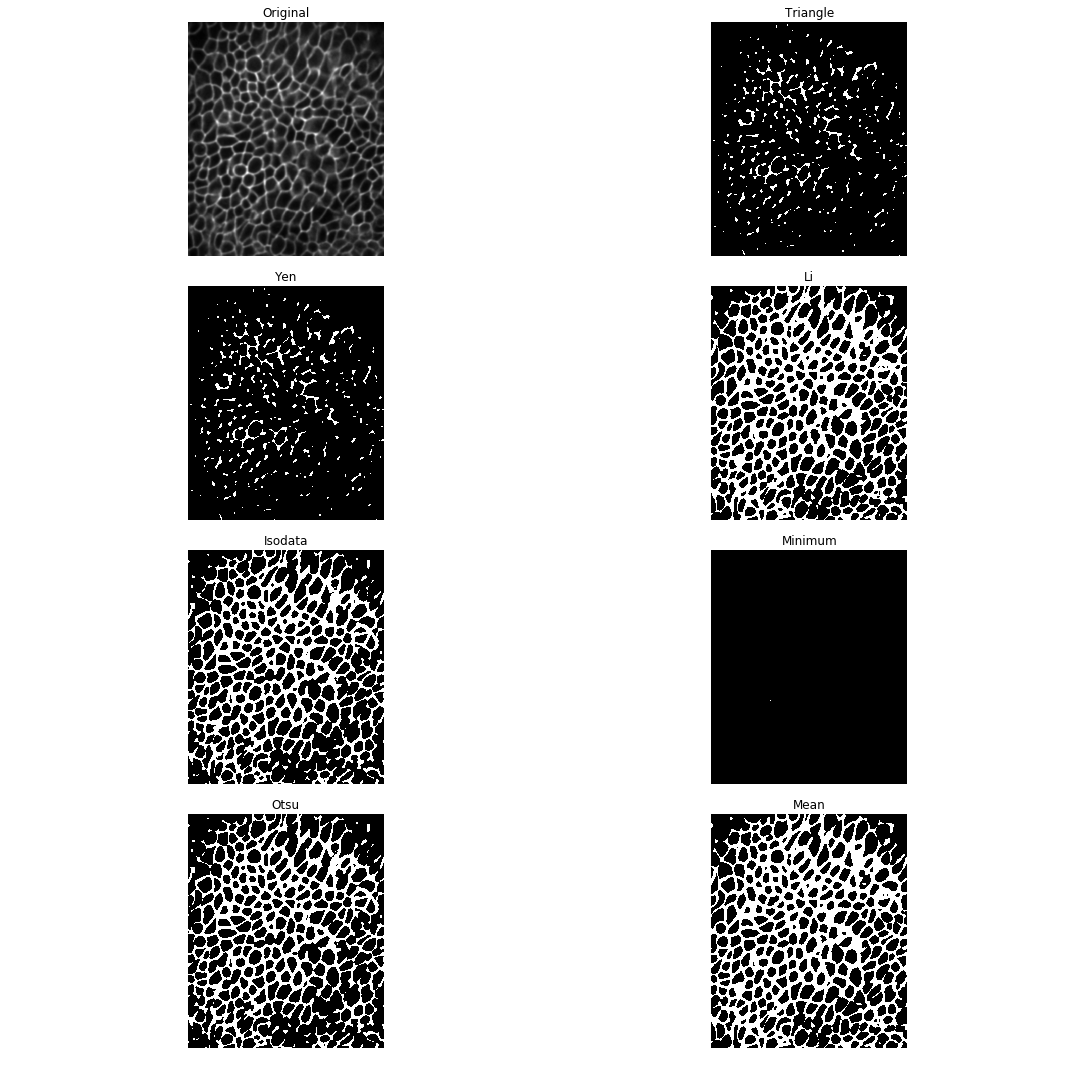

In [7]:
try_all_threshold(green_smooth, figsize=(15,15))

Adaptive thresholding

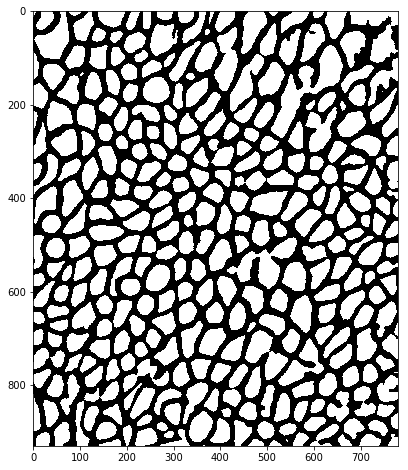

In [8]:
adaptive_threshold = threshold_local(green_smooth, block_size=101, offset=1)
bin_img = green_smooth > adaptive_threshold
bin_img = ndi.binary_fill_holes(np.logical_not(bin_img))
plt.figure(figsize=(8,8))
plt.imshow(bin_img, cmap='gray')

Show segmentation result obtained from adaptive thresholding

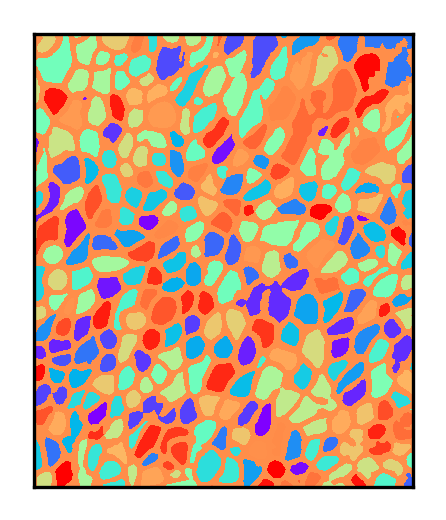

In [10]:
green_components = ndi.label(bin_img)[0] 

# Create new colormap with randomly ordered colors
vals = np.linspace(0,1,256)
np.random.shuffle(vals)
cmap = plt.cm.colors.ListedColormap(plt.cm.rainbow(vals))

plt.figure(figsize=(2,2), dpi=300)
plt.imshow(green_components, interpolation='none', cmap=cmap)    
plt.xticks([])
plt.yticks([])
plt.show() 

#### Improve segmentation
- Distance transform
  - Compute distance to boundary
  - Find maxima to obtain cell markers
- Watershed algorithm
  - Grow cell marker regions to obtain segmentation

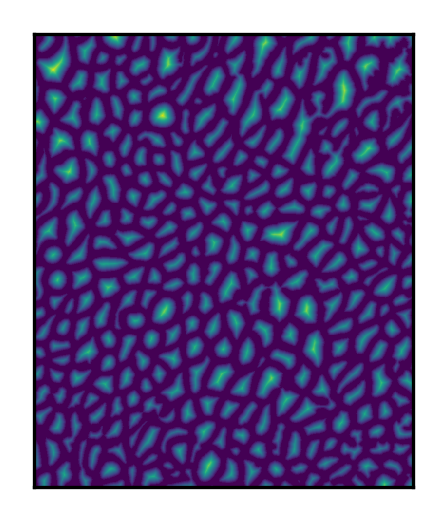

In [11]:
green_dt = ndi.distance_transform_edt(bin_img)

plt.figure(figsize=(2,2), dpi=300)
plt.imshow(green_dt, interpolation='none')
plt.xticks([])
plt.yticks([])
plt.show()

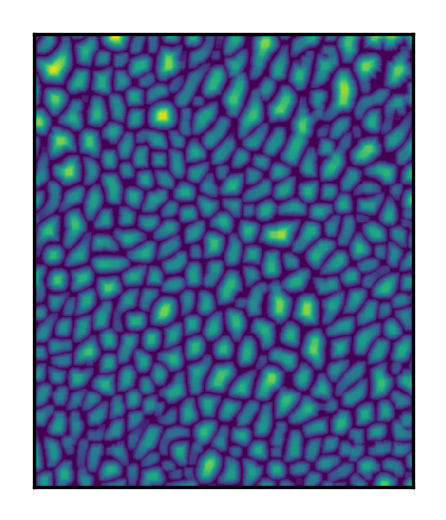

In [12]:
green_dt = ndi.filters.maximum_filter(green_dt, size=10) 
plt.figure(figsize=(2,2), dpi=300)
plt.imshow(green_dt, interpolation='none')
plt.xticks([])
plt.yticks([])
plt.show()

Find local maxima

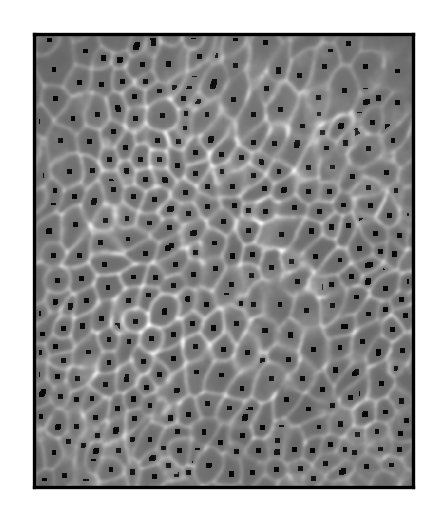

In [13]:
from skimage.feature import peak_local_max
green_max = peak_local_max(green_dt, indices=False, min_distance=10)
green_max = ndi.label(green_max)[0]                                   

plt.figure(figsize=(2,2), dpi=300)
plt.imshow(green_smooth, cmap='gray', interpolation='none')
plt.imshow(green_max==0, cmap='gray', interpolation='none', alpha=0.4) 
plt.xticks([])
plt.yticks([])
plt.show()

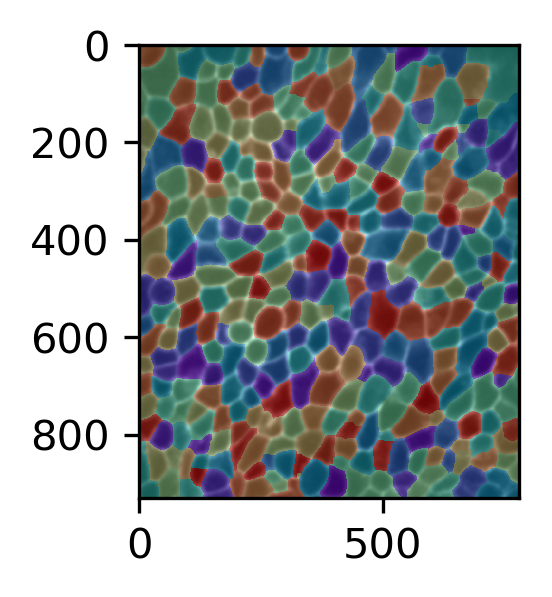

In [14]:
from skimage.morphology import watershed
green_ws = watershed(green_smooth, green_max)

vals = np.linspace(0,1,256)
np.random.shuffle(vals)
cmap = plt.cm.colors.ListedColormap(plt.cm.rainbow(vals))

plt.figure(figsize=(2,2), dpi=300)
plt.imshow(green_smooth, cmap='gray', interpolation='none')
plt.imshow(green_ws, interpolation='none', alpha=0.4, cmap=cmap) 
plt.show()

#### Post-processing
- Remove cells at the boundary
- Measure cell size
- Find cell centroids

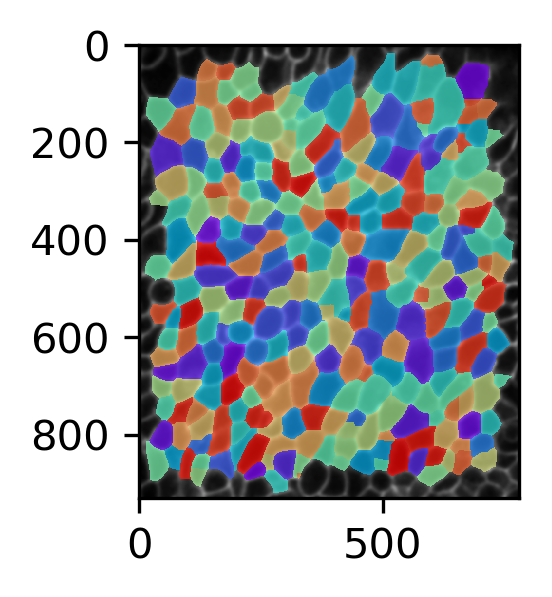

In [15]:
# Construct boundary mask: 1's along boundary, 0's in the middle
boundary_mask = np.ones_like(green_ws)  
boundary_mask[1:-1,1:-1] = 0

# For all segmented cells
current_label = 1
for cell_id in np.unique(green_ws):
    
    # If number of pixels touching boundary > 0
    if np.sum((green_ws==cell_id)*boundary_mask) != 0:
        green_ws[green_ws==cell_id] = 0
    else:
        green_ws[green_ws==cell_id] = current_label
        current_label += 1
        
# Overlay result
plt.figure(figsize=(2,2), dpi=300)
plt.imshow(green_smooth,cmap='gray',interpolation='none')
plt.imshow(np.ma.array(green_ws,mask=green_ws==0),interpolation='none',alpha=0.7, cmap=cmap) 
plt.show()

Plot histogram of cell sizes (measured in pixels)

In [16]:
cell_sizes = []

for cell_id in np.unique(green_ws)[1:]:
    
    cell_mask = green_ws==cell_id  
    cell_sizes.append(np.sum(cell_mask))

(array([ 9., 40., 70., 77., 47., 23., 10.,  6.,  1.,  1.]),
 array([  83. ,  654.4, 1225.8, 1797.2, 2368.6, 2940. , 3511.4, 4082.8,
        4654.2, 5225.6, 5797. ]),
 <a list of 10 Patch objects>)

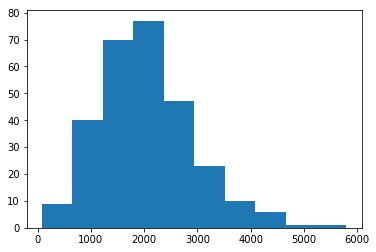

In [17]:
plt.hist(cell_sizes)

Find centroids of cells

In [18]:
N = len(cell_sizes)
labels = np.unique(green_ws)[1:] 

cen = np.zeros((N,2))
for index,label in enumerate(labels):
    cen[index,:] = ndi.measurements.center_of_mass(green_ws==label)

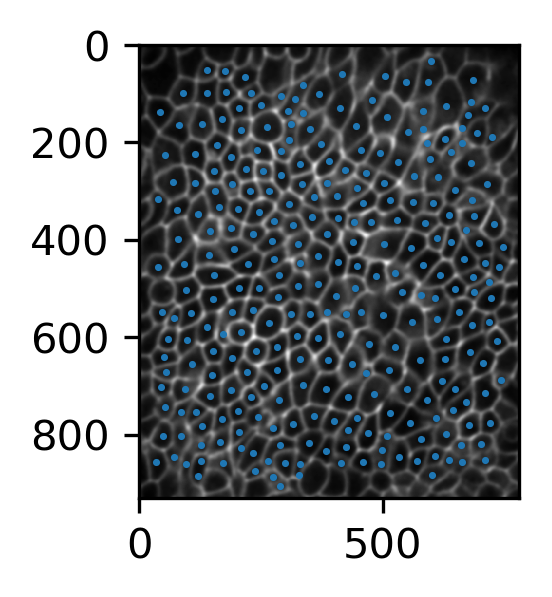

In [19]:
plt.figure(figsize=(2,2), dpi=300)
plt.imshow(green_smooth,cmap='gray',interpolation='none')
plt.scatter(cen[:,1], cen[:,0], s=0.5)
plt.show()